# Prescriptive Analytics on Historical Product Demand

##### Dataset Source: https://www.kaggle.com/datasets/felixzhao/productdemandforecasting?resource=download

## 1. Import Required Libraries

In [8]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pulp import LpMinimize, LpProblem, LpVariable, lpSum, LpStatus

## 2. Load Dataset

In [10]:
df = pd.read_csv("Historical Product Demand.csv")
df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


## 3. Data Cleaning

In [12]:
# Convert Order_Demand to numeric
df["Order_Demand"] = df["Order_Demand"].astype(str)
df["Order_Demand"] = df["Order_Demand"].str.replace("(", "", regex=False)
df["Order_Demand"] = df["Order_Demand"].str.replace(")", "", regex=False)
df["Order_Demand"] = df["Order_Demand"].astype(int)

# Convert Date column
df["Date"] = pd.to_datetime(df["Date"])

## 4. Monthly Demand Trend (Descriptive Analytics)

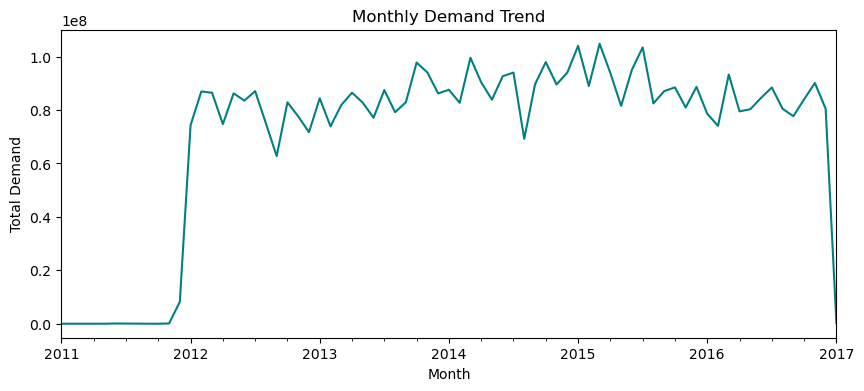

In [53]:
monthly_demand = df.groupby(df["Date"].dt.to_period("M"))["Order_Demand"].sum()

monthly_demand.plot(figsize=(10,4), color = 'teal')
plt.title("Monthly Demand Trend")
plt.xlabel("Month")
plt.ylabel("Total Demand")
plt.show()

## 5. Demand Statistics

In [16]:
avg_demand = df["Order_Demand"].mean()
max_demand = df["Order_Demand"].max()

avg_demand, max_demand

(4906.976917244832, 4000000)

## 6. Cost Parameters

In [18]:
purchase_cost = 10     # cost per unit
holding_cost = 2       # cost per surplus unit
shortage_cost = 15     # penalty per shortage unit
selling_price = 20

## 7. Linear Programming (LP)

In [20]:
lp_model = LpProblem("Inventory_Optimization_LP", LpMinimize)

order_qty = LpVariable("Order_Quantity", lowBound=0)
surplus = LpVariable("Surplus", lowBound=0)
shortage = LpVariable("Shortage", lowBound=0)

# Objective Function
lp_model += (
    purchase_cost * order_qty +
    holding_cost * surplus +
    shortage_cost * shortage
)

# Demand balance constraint
lp_model += order_qty + shortage - surplus == avg_demand

lp_model.solve()

print("LP Status:", LpStatus[lp_model.status])
print("Optimal Order Quantity (LP):", order_qty.value())

LP Status: Optimal
Optimal Order Quantity (LP): 4906.9769


## 8. LP Visualization

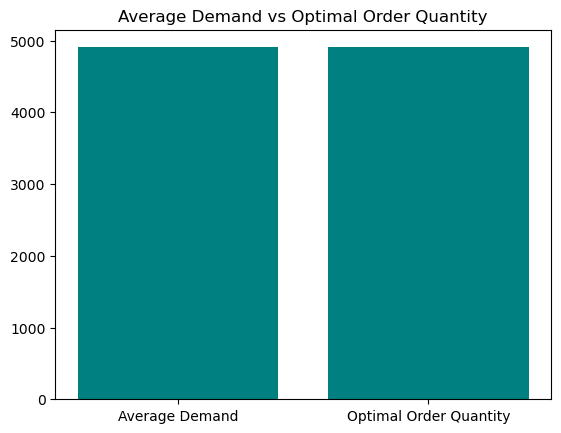

In [57]:
plt.bar(
    ["Average Demand", "Optimal Order Quantity"],
    [avg_demand, order_qty.value()],
    color = 'teal'
)
plt.title("Average Demand vs Optimal Order Quantity")
plt.show()

The LP model determines the most cost-efficient order quantity by balancing purchasing, holding, and shortage costs.

## 9. Integer Programming (IP)

In [25]:
order_qty_int = LpVariable("Order_Quantity_Integer", lowBound=0, cat="Integer")
surplus_int = LpVariable("Surplus_Integer", lowBound=0)
shortage_int = LpVariable("Shortage_Integer", lowBound=0)

ip_model = LpProblem("Inventory_Optimization_IP", LpMinimize)

ip_model += (
    purchase_cost * order_qty_int +
    holding_cost * surplus_int +
    shortage_cost * shortage_int
)

ip_model += order_qty_int + shortage_int - surplus_int == avg_demand

ip_model.solve()

print("IP Status:", LpStatus[ip_model.status])
print("Optimal Order Quantity (IP):", order_qty_int.value())

IP Status: Optimal
Optimal Order Quantity (IP): 4907.0


## 10. Mixed Integer Programming (MIP)

In [27]:
fixed_order_cost = 100

order_flag = LpVariable("Order_Flag", cat="Binary")

mip_model = LpProblem("Inventory_Optimization_MIP", LpMinimize)

mip_model += (
    purchase_cost * order_qty_int +
    holding_cost * surplus_int +
    shortage_cost * shortage_int +
    fixed_order_cost * order_flag
)

mip_model += order_qty_int + shortage_int - surplus_int == avg_demand
mip_model += order_qty_int <= max_demand * order_flag

mip_model.solve()

print("MIP Status:", LpStatus[mip_model.status])
print("Optimal Order Quantity (MIP):", order_qty_int.value())
print("Order Decision (1=Order, 0=No Order):", order_flag.value())

MIP Status: Optimal
Optimal Order Quantity (MIP): 4907.0
Order Decision (1=Order, 0=No Order): 1.0


## 11. LP vs IP vs MIP Comparison

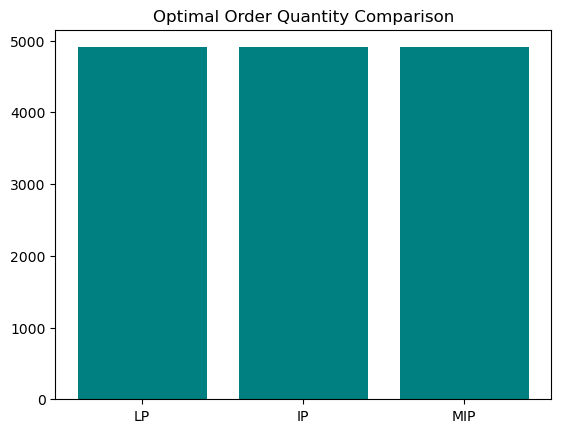

In [61]:
models = ["LP", "IP", "MIP"]
order_values = [
    order_qty.value(),
    order_qty_int.value(),
    order_qty_int.value(),
]

plt.bar(models, order_values, color = 'teal')
plt.title("Optimal Order Quantity Comparison")
plt.show()

All models provide similar order quantities, but MIP is the most realistic as it includes fixed ordering costs.

## 12. Profit Analysis

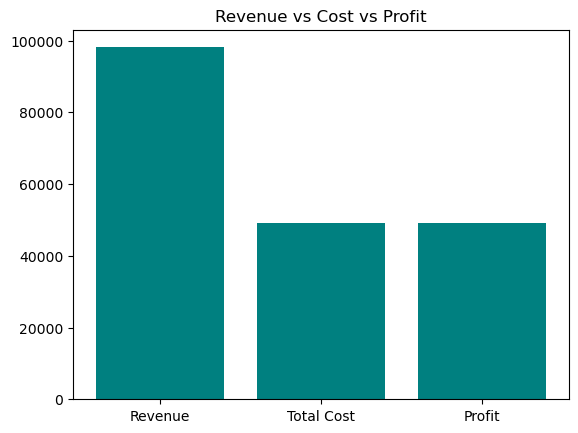

In [63]:
revenue = selling_price * avg_demand
total_cost = purchase_cost * order_qty.value()
profit = revenue - total_cost

plt.bar(["Revenue", "Total Cost", "Profit"], [revenue, total_cost, profit], color = 'teal')
plt.title("Revenue vs Cost vs Profit")
plt.show()

Optimized ordering reduces costs and improves overall profitability.

## 13. Sensitivity Analysis

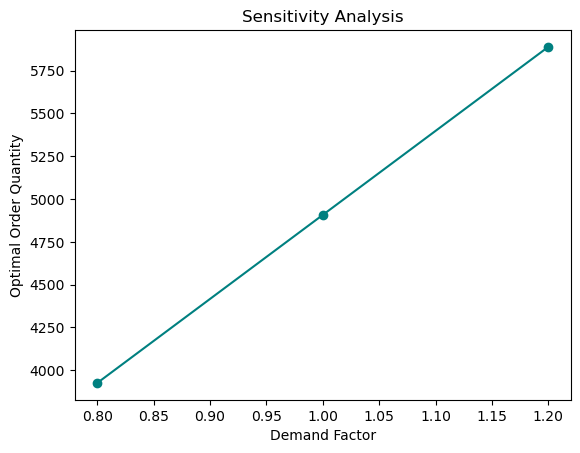

In [65]:
demand_factors = [0.8, 1.0, 1.2]
optimal_orders = [avg_demand * d for d in demand_factors]

plt.plot(demand_factors, optimal_orders, marker="o", color = 'teal')
plt.xlabel("Demand Factor")
plt.ylabel("Optimal Order Quantity")
plt.title("Sensitivity Analysis")
plt.show()

The optimal order quantity increases proportionally with demand, showing the model’s robustness.

## 14. Final Conclusion

- This project demonstrates how prescriptive analytics converts historical demand data
- into optimal inventory decisions using LP, IP, and MIP models.
- These techniques help minimize cost, manage uncertainty, and maximize profitability.